In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, BatchNormalization
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient, generate_blob_sas, BlobSasPermissions
from datetime import datetime, timedelta
import urllib.request
from PIL import Image
import numpy as np
#from azure.ai.ml import MLClient
#from azure.identity import DefaultAzureCredential
#import time
#import required libraries for environments examples
#from azure.ai.ml.entities import Environment, BuildContext
#Enter details of your Azure Machine Learning workspace
#subscription_id = '8725028b-cfda-470d-8e19-a3cd10b0a650'
#resource_group = 'motzai3'
#workspace = 'motzai3'
#import multiprocessing
#connect to the workspace
#ml_client = MLClient(DefaultAzureCredential(), subscription_id, resource_group, workspace)

2023-08-14 12:42:54.226747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 12:43:01.086471: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-14 12:43:01.086572: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-14 12:43:01.086582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [5]:
account = "Test"   # Azure account name
key = "test"      # Azure Storage account access key  
connect_str = "test"
container = "data"
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

In [6]:
def generate_SAS():
    blob_list = []
    container_client_analysis = blob_service_client.get_container_client(container=container)

    
    blob_list = []
    for blob_i in container_client_analysis.list_blobs():
        blob_list.append(blob_i.name)
        
    sas_url_lst = []
    
    for j in range(len(blob_list)):
        sas_analysis = generate_blob_sas(account_name = account,
                        container_name = container,
                        blob_name = blob_list[j],
                        account_key=key,
                        permission=BlobSasPermissions(read=True),
                        expiry=datetime.utcnow() + timedelta(hours=1))
        sas_url = 'https://' + account+'.blob.core.windows.net/' + container + '/' + blob_list[j] + '?' + sas_analysis
        sas_url_lst.append(sas_url)
    return sas_url_lst   

In [7]:
x= generate_SAS()

In [8]:
def load_dataset():
    lst_img = []
    # Open the image file
    #y = x[:100]
    for i in x:
        image_data = urllib.request.urlopen(i)
        image = Image.open(image_data)
        image = image.resize((50,50))
        image_array = np.array(image)
        lst_img.append(image_array)
        #print(image_array.shape)

    arr_img = np.array(lst_img)
    #arr_img = np.array(lst_img)
    split_ratio = 0.8
    np.random.shuffle(arr_img)
    size = int(arr_img.shape[0]*split_ratio) 
    training, test = arr_img[:size,:], arr_img[size:,:]
    return training,test

In [9]:
x_train,x_test = load_dataset()

In [10]:
#(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

In [11]:
x_test.shape

(2500, 50, 50)

In [12]:
test_image = x_train[0]


In [13]:
test_image

array([[149, 152, 154, ..., 175, 176, 177],
       [149, 152, 153, ..., 177, 176, 175],
       [149, 152, 153, ..., 178, 174, 173],
       ...,
       [ 24,  30,  37, ...,  98,  93,  91],
       [ 22,  29,  34, ..., 108, 109, 108],
       [ 19,  26,  27, ..., 107, 103,  99]], dtype=uint8)

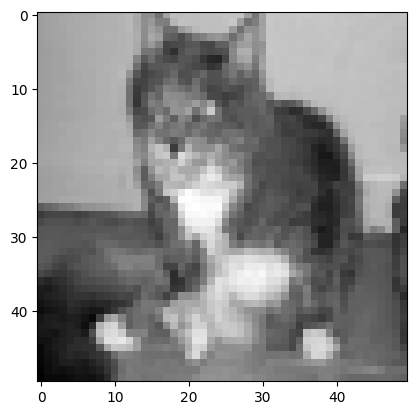

In [14]:
plt.imshow(test_image,cmap="gray")
plt.show()

In [15]:
x_train = x_train.astype("float32") / 255.0
x_train = tf.expand_dims(x_train, -1)
x_test = x_test.astype("float32") / 255.0
x_test = tf.expand_dims(x_train, -1)

In [16]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [17]:
latent_dim = 200

encoder_inputs = keras.Input(shape=(50 , 50, 1))
x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(200, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 25, 25, 512)  5120        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 25, 25, 512)  2048       ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 13, 13, 128)  589952      ['batch_normalization[0][0]

In [18]:
"""
latent_dim = 64

encoder_inputs = keras.Input(shape=(50 , 50, 1))
x = layers.Conv2D(1024, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
"""

'\nlatent_dim = 64\n\nencoder_inputs = keras.Input(shape=(50 , 50, 1))\nx = layers.Conv2D(1024, 3, activation="relu", strides=2, padding="same")(encoder_inputs)\nx = keras.layers.BatchNormalization()(x)\nx = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)\nx = keras.layers.BatchNormalization()(x)\nx = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)\nx = keras.layers.BatchNormalization()(x)\nx = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)\nx = keras.layers.BatchNormalization()(x)\nx = layers.Flatten()(x)\nx = layers.Dense(128, activation="relu")(x)\n\nz_mean = layers.Dense(latent_dim, name="z_mean")(x)\nz_log_var = layers.Dense(latent_dim, name="z_log_var")(x)\nz = Sampling()([z_mean, z_log_var])\nencoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")\nencoder.summary()\n'

In [19]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(512, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Dense(25 * 25 * latent_dim, activation="relu")(latent_inputs)
x = layers.Reshape((25, 25, latent_dim))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=1, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=1, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=1, padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_2 (Dense)             (None, 125000)            25125000  
                                                                 
 reshape (Reshape)           (None, 25, 25, 200)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 50, 50, 128)      230528    
 nspose)                                                         
                                                                 
 batch_normalization_5 (Batc  (None, 50, 50, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 50, 50, 128)      1475

In [20]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



In [21]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [22]:
tf.debugging.set_log_device_placement(True)

In [23]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [24]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [27]:
x_train, x_test = x_train,x_test

vae = VAE(encoder, decoder)
"""
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=5000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
"""
opt = keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=opt,loss='sparse_categorical_crossentropy')
#vae.compile(optimizer='adam',loss='sparse_categorical_crossentropy')
#vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, loss='binary_crossentropy'))
vae.fit(x_train, epochs=200, batch_size=16)

Epoch 1/200
625/625 [==============================] - 30s 41ms/step - loss: 1488.9230 - reconstruction_loss: 1454.0579 - kl_loss: 33.6972
Epoch 2/200
625/625 [==============================] - 25s 41ms/step - loss: 1485.9761 - reconstruction_loss: 1452.6633 - kl_loss: 33.9985
Epoch 3/200
625/625 [==============================] - 26s 41ms/step - loss: 1488.1525 - reconstruction_loss: 1451.5555 - kl_loss: 34.3269
Epoch 4/200
625/625 [==============================] - 26s 41ms/step - loss: 1486.4851 - reconstruction_loss: 1450.7513 - kl_loss: 34.5460

In [ ]:
"""
x_train, x_test = x_train,x_test

vae = VAE(encoder, decoder)
opt = keras.optimizers.Adam(learning_rate=0.1)
vae.compile(optimizer=opt,loss='sparse_categorical_crossentropy')
#vae.compile(optimizer='adam',loss='sparse_categorical_crossentropy')
#vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, loss='binary_crossentropy'))
vae.fit(x_train, epochs=5, batch_size=16)
"""

In [28]:
x_test_encoded = encoder.predict(x_test, batch_size=16)

625/625 [==============================] - 1s 2ms/step


In [29]:
len(x_test_encoded)

3

In [30]:
x_test_encoded[2].shape

(10000, 200)

In [31]:
x_decoded = vae.decoder.predict(x_test_encoded[0])

313/313 [==============================] - 6s 19ms/step


In [32]:
x_decoded.shape

(10000, 50, 50, 1)

In [33]:
import matplotlib.pyplot as plt

In [34]:
x_decoded.shape

(10000, 50, 50, 1)

In [35]:
x_test.shape

TensorShape([10000, 50, 50, 1, 1])

In [36]:
x_test2 = x_test

In [37]:
x_test2[0].shape

TensorShape([50, 50, 1, 1])

In [38]:
x_test2 = x_test2[:,:,:,0]

In [39]:
x_test2.shape

TensorShape([10000, 50, 50, 1])

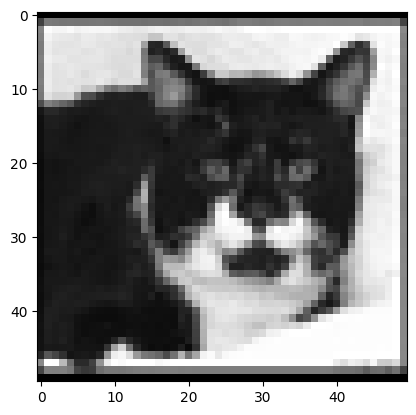

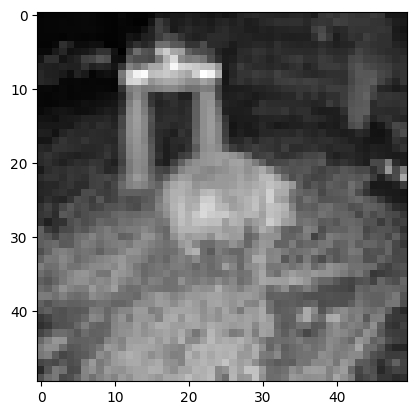

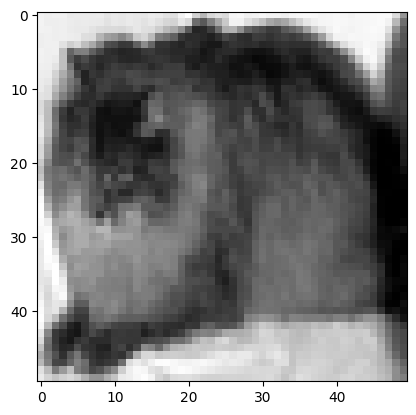

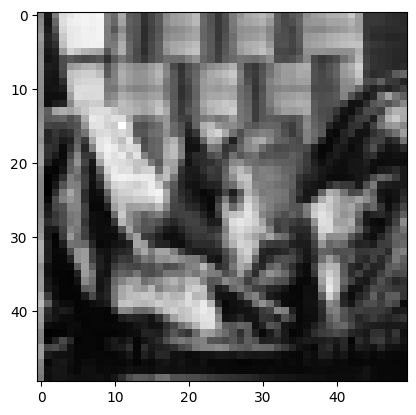

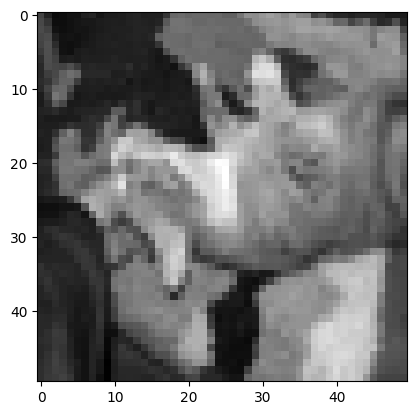

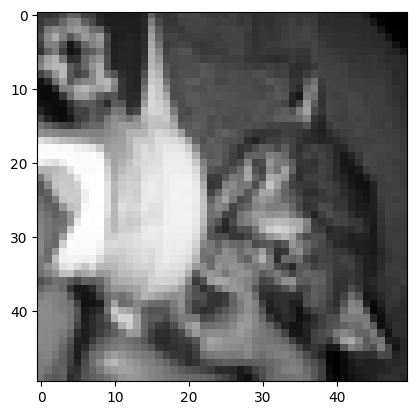

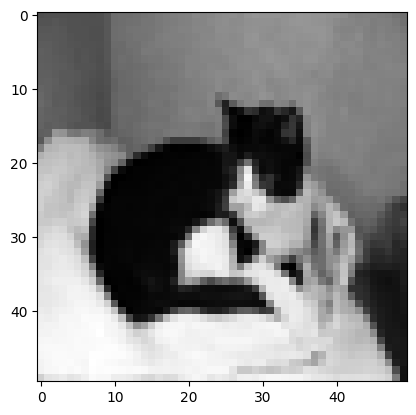

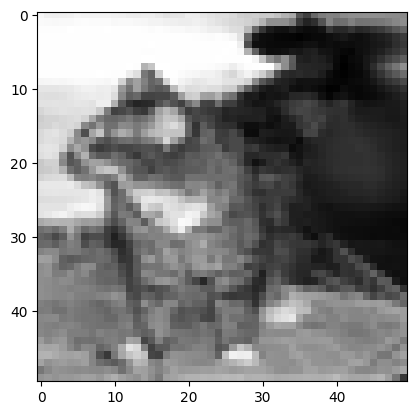

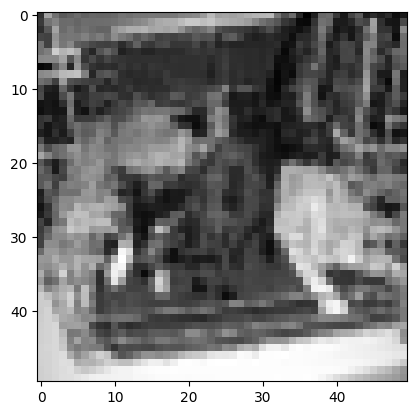

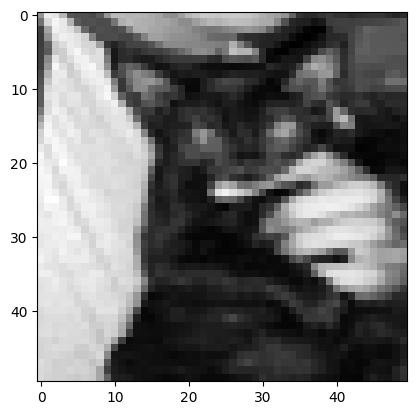

In [40]:
for i in range(50,60):
    plt.imshow(x_test2[i],cmap="gray")
    plt.show()

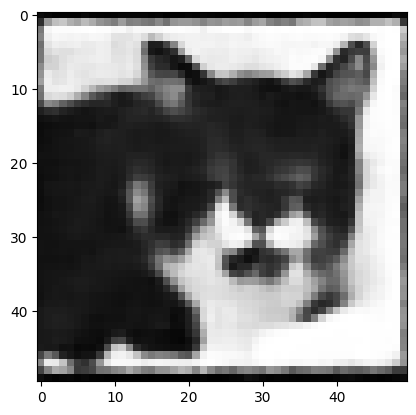

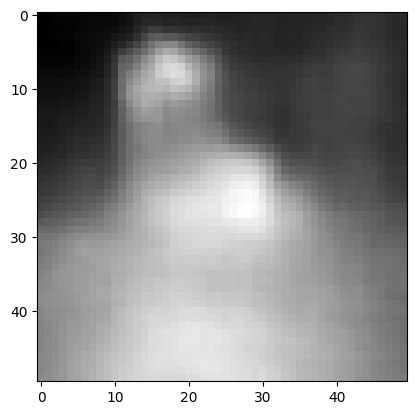

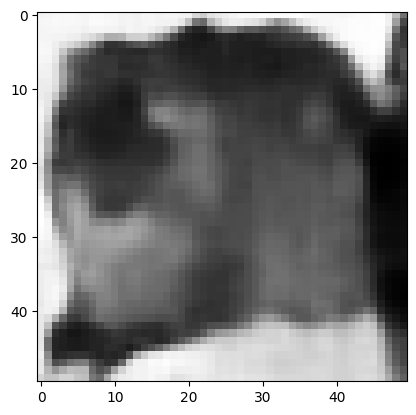

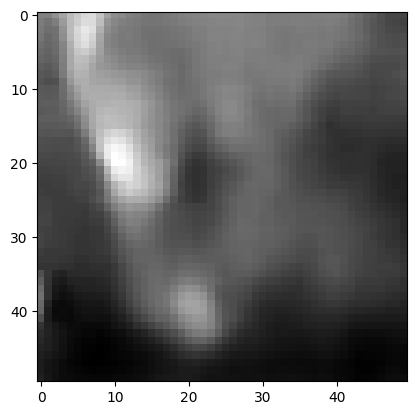

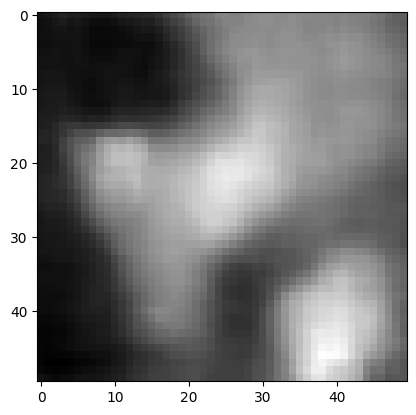

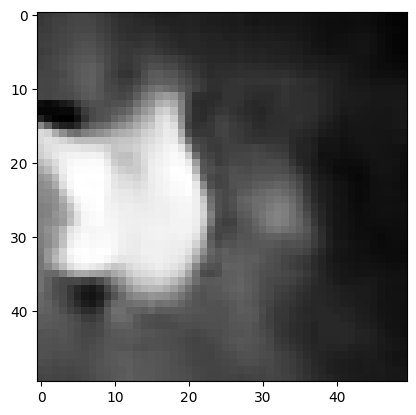

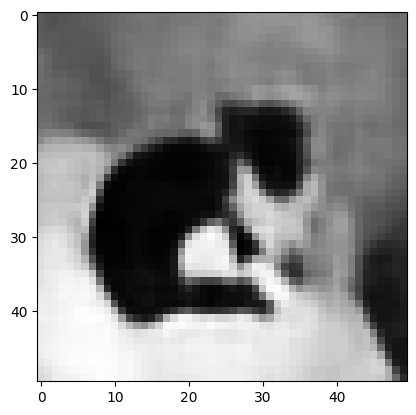

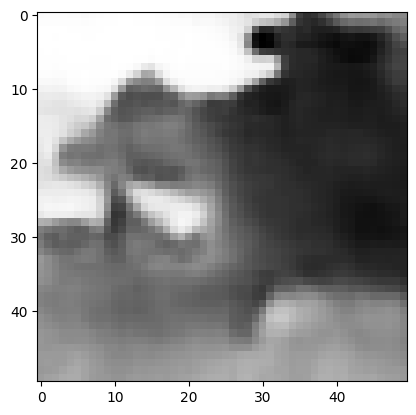

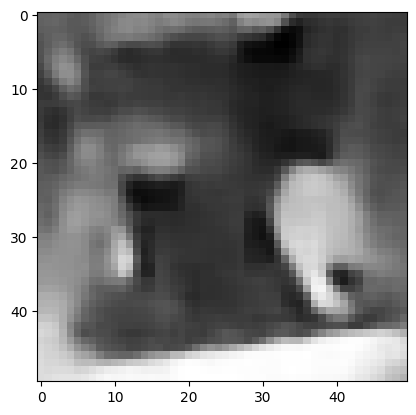

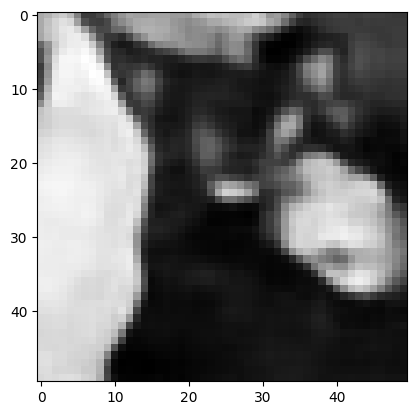

In [41]:
for i in range(50,60):
    plt.imshow(x_decoded[i],cmap="gray")
    plt.show()